Visualizing the innards of the three optimization for adaptive behavior on serial neurogym.

In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm, trange
import seaborn as sns
from utils import get_logs_and_files, convert_train_to_test_idx


In [2]:
# exp_name= 'neurips'
data_folder = './../files/cluster_fu/'
exp_name= 'random_gates_add'
# exp_name= 'neurips/brittle_policy'
# exp_name= 'neurips/td'
# exp_name= 'neurips/bu'
print('current folder: ', os.getcwd())
filenames = os.listdir(data_folder + exp_name)
testing_log_files = [logfile for logfile in filenames if logfile.__contains__('testing_log')]
training_log_files = [logfile for logfile in filenames if logfile.__contains__('training_log')]
config_files = [logfile for logfile in filenames if logfile.__contains__('config')]
# print('config files: ', config_files)
print('testing_logs :', testing_log_files)
print('training_logs :', training_log_files)

current folder:  /home/ahummos/code/multiplicative/analysis
testing_logs : ['testing_log_seed0_paradigm_seq_add_tasks_10_0.0_0.0_0.0_.npy', 'testing_log_seed0_paradigm_seq_add_tasks_10_0.0_1.0_0.0_.npy', 'testing_log_seed0_paradigm_seq_add_tasks_10_400.0_0.0_0.0_.npy', 'testing_log_seed0_paradigm_seq_add_tasks_10_400.0_1.0_0.0_.npy', 'testing_log_seed0_paradigm_seq_add_tasks_5_0.0_0.0_0.0_.npy', 'testing_log_seed0_paradigm_seq_add_tasks_5_0.0_1.0_0.0_.npy', 'testing_log_seed0_paradigm_seq_add_tasks_5_400.0_0.0_0.0_.npy', 'testing_log_seed0_paradigm_seq_add_tasks_5_400.0_1.0_0.0_.npy', 'testing_log_seed1_paradigm_seq_add_tasks_10_0.0_0.0_0.0_.npy', 'testing_log_seed1_paradigm_seq_add_tasks_10_0.0_1.0_0.0_.npy', 'testing_log_seed1_paradigm_seq_add_tasks_10_400.0_0.0_0.0_.npy', 'testing_log_seed1_paradigm_seq_add_tasks_10_400.0_1.0_0.0_.npy', 'testing_log_seed1_paradigm_seq_add_tasks_5_0.0_0.0_0.0_.npy', 'testing_log_seed1_paradigm_seq_add_tasks_5_0.0_1.0_0.0_.npy', 'testing_log_seed1_par

In [47]:
idx = 0
training_file= data_folder+ training_log_files[idx]
testing_file= data_folder+ testing_log_files[idx]
config_file= data_folder+ config_files[idx]
config= np.load( config_file, allow_pickle=True).item()
training_log = np.load( training_file, allow_pickle=True).item()
testing_log = np.load( testing_file, allow_pickle=True).item()


IndexError: list index out of range

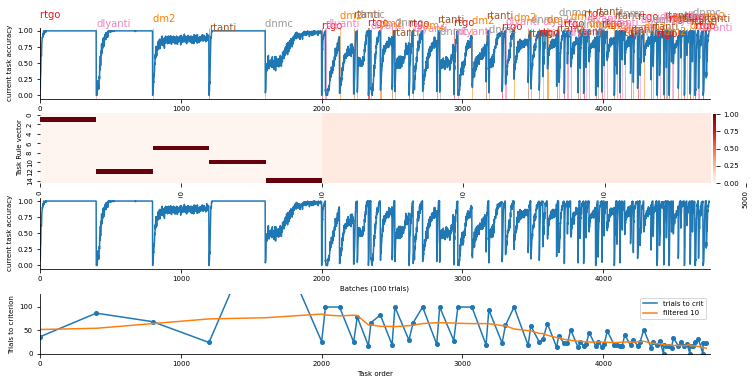

In [9]:
def plot_long_term_cluster_discovery( config, training_log, testing_log):
    if len(training_log.bu_context_ids) > 0: context_ids =  training_log.bu_context_ids
    elif len(training_log.td_context_ids) > 0: context_ids =  training_log.td_context_ids
    else: 
        # len(training_log.md_context_ids) > 0: 
        policy_context_id = np.ones([1,config.md_size])/config.md_size
        context_ids = [policy_context_id.repeat(config.batch_size, 0)] * training_log.stamps[-1]


    x0, x1 = 0, training_log.stamps[-1]
    no_of_values = len(config.tasks)
    norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
    cmap_obj = mpl.cm.get_cmap('Set1') # tab20b tab20
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

    switches=  training_log.switch_trialxxbatch[:] 
    # switches=  training_log.switch_trialxxbatch[1:] # earlier on I must have added zero as a switch trial 

    fig, axes = plt.subplots(4,1, figsize=[12,6], sharex = False)

    ax = axes[0]
    # print(ax.get_position())
    # ax.set_position(mpl.transforms.Bbox([[0.125, 0.715], [.747, 0.880]]))
    ax.plot(np.array(training_log.stamps)[x0:x1], np.array(training_log.accuracies)[x0:x1])
    for ri in range(len(switches)-1):
        ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri]+1, color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.5)
        id = training_log.switch_task_id[ri]
        task_name = config.human_task_names[id]
        ax.text(training_log.switch_trialxxbatch[ri], 1.0 + np.random.uniform(-0.1, 0.25), task_name, color= cmap.to_rgba(id) , fontsize=10)
    ax.set_ylabel('current task accuracy')
    ax.set_xlim([x0, x1])
    
    ax = axes[1] # context ids
    md = np.stack([m[0] for m in training_log.md_context_ids])
    # print(fig.get_axes())
    im = sns.heatmap(md.T, cmap='Reds', ax = ax)#, vmax=md.max()/3)
    # print(fig.get_axes())
    # print('colorbar pos:', fig.get_axes()[-1].get_position())
    fig.get_axes()[-1].set_position(mpl.transforms.Bbox([[0.9037,0.52],[.90785, 0.680]]))
    # ax.get_shared_x_axes().join(ax, axes[0])
    ax.set_xticks(axes[0].get_xticks())
    ax.set_xticklabels(axes[0].get_xticklabels())
    ax.set_xlabel('Batches (100 trials)')
    ax.set_ylabel('Task Rule vector')
    
    ax.set_position(mpl.transforms.Bbox([[0.125,0.52],[.942, 0.683]]))
    # print(ax.get_position())

    ax = axes[2] # mean_bu
    ax.plot(np.array(training_log.stamps)[x0:x1], np.array(training_log.accuracies)[x0:x1])
    ax.set_xlim([x0, x1])
    ax.set_ylabel('current task accuracy')
    ax.set_xlabel('Batches (100 trials)')

    ax = axes[3]
    # ax.plot(training_log.trials_to_crit, label = 'trials to crit')
    ax.plot(training_log.switch_trialxxbatch, training_log.trials_to_crit, label = 'trials to crit', color='tab:blue')
    ax.plot(training_log.switch_trialxxbatch,training_log.trials_to_crit, 'o', markersize=4, color='tab:blue')
    filter=10
    filtered_mean = np.convolve(np.array(training_log.trials_to_crit), np.ones(filter)/filter, 'same')
    ax.plot(training_log.switch_trialxxbatch,filtered_mean, label=f'filtered {filter}', color='tab:orange')
    ax.set_ylabel('Trials to criterion')
    ax.set_xlabel('Task order')
    ax.set_xlim([x0, x1])
    ax.set_ylim(0, filtered_mean.max()*1.5)
    ax.legend()
    # print(ax.get_position())
    ax.set_position(mpl.transforms.Bbox([[0.125,0.125],[.90, 0.263]]))
    # fig.tight_layout()
plot_long_term_cluster_discovery(config, training_log, testing_log)

In [6]:
# exp_name=''
seed = 1
loops = 0.0
task_rule = 1.0
no_of_tasks = 5
search_strs=[f'seed{seed}_', f'tasks_{no_of_tasks}_{loops:3.1f}_{task_rule:1.1f}_0.0']
exp_name = 'random_gates_mul'
testing_logs, test_files = get_logs_and_files(data_folder, exp_name, file_sig='testing_log', search_strs=search_strs)
training_logs, train_files = get_logs_and_files(data_folder, exp_name, file_sig='training_log', search_strs=search_strs)
configs, config_files = get_logs_and_files(data_folder, exp_name, file_sig='config', search_strs=search_strs)
config_files
    
testing_log = testing_logs[0]
training_log = training_logs[0]
config = configs[0]


['config_seed1_paradigm_seq_mul_tasks_5_0.0_1.0_0.0_.npy']

In [39]:
seed = 1
loops = 0.0
task_rule = 1.0
no_of_tasks = 5
def load_simulation(data_folder, exp_name, seed, loops, task_rule, no_of_tasks):
    search_strs=[f'seed{seed}_', f'tasks_{no_of_tasks}_{loops:3.1f}_{task_rule:1.1f}_0.0']
    testing_logs, test_files = get_logs_and_files(data_folder, exp_name, file_sig='testing_log', search_strs=search_strs)
    training_logs, train_files = get_logs_and_files(data_folder, exp_name, file_sig='training_log', search_strs=search_strs)
    configs, config_files = get_logs_and_files(data_folder, exp_name, file_sig='config', search_strs=search_strs)
    config_files
    
    if len(training_logs) > 0:
        testing_log = testing_logs[0]
        training_log = training_logs[0]
        config = configs[0]
        assert len(training_logs) == 1, 'more than one training_log found!'
    else:
        print( f'unable to load {search_strs}!')
        testing_log, training_log, config = None, None, None        
    return config,training_log,testing_log


config, training_log, testing_log = load_simulation(data_folder, 'random_gates_mul', seed, loops, task_rule, no_of_tasks)

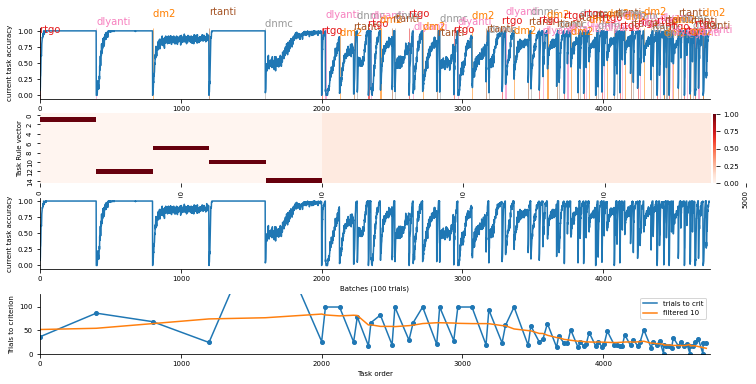

In [14]:

plot_long_term_cluster_discovery(config, training_log, testing_log)

unable to load ['seed2_', 'tasks_5_400.0_0.0_0.0']!


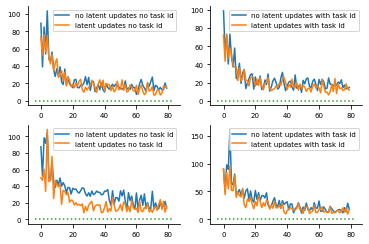

In [41]:
fig, axes = plt.subplots(2,2)
exp_name = 'random_gates_add'
exps = []
data = defaultdict(list)
no_of_tasks = 5
for loop in [0.0, 400.0]:
    for task_rule in [0.0, 1.0]:
        for seed in range(5):
            config, training_log, testing_log = load_simulation(data_folder, exp_name, seed, loop, task_rule, no_of_tasks)
            if not config is None: # if exp actually loaded and exists.
                exps.append({'loop': loop, 'task_rule': task_rule, 'no_of_tasks': no_of_tasks, 'seed': seed})
                data['ttcs'].append(training_log.trials_to_crit)

ax = axes[0,0]
ttcs = np.stack([data['ttcs'][i]  for i in range(len(data['ttcs'])) if exps[i]['loop'] == 0.0 and exps[i]['task_rule'] == 0.0])
ax.plot(ttcs.mean(0), label = 'no latent updates no task id')
ttcs = np.stack([data['ttcs'][i]  for i in range(len(data['ttcs'])) if exps[i]['loop'] == 400.0 and exps[i]['task_rule'] == 0.0])
ax.plot(ttcs.mean(0), label = 'latent updates no task id')
ax.plot(ax.get_xlim(), [0, 0], ':')
ax.legend()

ax = axes[0,1]
ttcs = np.stack([data['ttcs'][i]  for i in range(len(data['ttcs'])) if exps[i]['loop'] == 0.0 and exps[i]['task_rule'] == 1.0])
ax.plot(ttcs.mean(0), label = 'no latent updates with task id')
ttcs = np.stack([data['ttcs'][i]  for i in range(len(data['ttcs'])) if exps[i]['loop'] == 400.0 and exps[i]['task_rule'] == 1.0])
ax.plot(ttcs.mean(0), label = 'latent updates with task id')
ax.plot(ax.get_xlim(), [0, 0], ':')
ax.legend()

exp_name = 'random_gates_mul'
exps = []
data = defaultdict(list)
no_of_tasks = 5
for loop in [0.0, 400.0]:
    for task_rule in [0.0, 1.0]:
        for seed in range(5):
            config, training_log, testing_log = load_simulation(data_folder, exp_name, seed, loop, task_rule, no_of_tasks)
            if not config is None: # if exp actually loaded and exists.
                exps.append({'loop': loop, 'task_rule': task_rule, 'no_of_tasks': no_of_tasks, 'seed': seed})
                data['ttcs'].append(training_log.trials_to_crit)

ax = axes[1,0]
ttcs = np.stack([data['ttcs'][i]  for i in range(len(data['ttcs'])) if exps[i]['loop'] == 0.0 and exps[i]['task_rule'] == 0.0])
ax.plot(ttcs.mean(0), label = 'no latent updates no task id')
ttcs = np.stack([data['ttcs'][i]  for i in range(len(data['ttcs'])) if exps[i]['loop'] == 400.0 and exps[i]['task_rule'] == 0.0])
ax.plot(ttcs.mean(0), label = 'latent updates no task id')
ax.plot(ax.get_xlim(), [0, 0], ':')
ax.legend()

ax = axes[1,1]
ttcs = np.stack([data['ttcs'][i]  for i in range(len(data['ttcs'])) if exps[i]['loop'] == 0.0 and exps[i]['task_rule'] == 1.0])
ax.plot(ttcs.mean(0), label = 'no latent updates with task id')
ttcs = np.stack([data['ttcs'][i]  for i in range(len(data['ttcs'])) if exps[i]['loop'] == 400.0 and exps[i]['task_rule'] == 1.0])
ax.plot(ttcs.mean(0), label = 'latent updates with task id')
ax.plot(ax.get_xlim(), [0, 0], ':')
ax.legend()



In [32]:
tt = np.stack(ttcs)

In [33]:
tt.shape

(5, 80)

Bbox(x0=0.125, y0=0.7158695652173913, x1=0.9, y1=0.88)


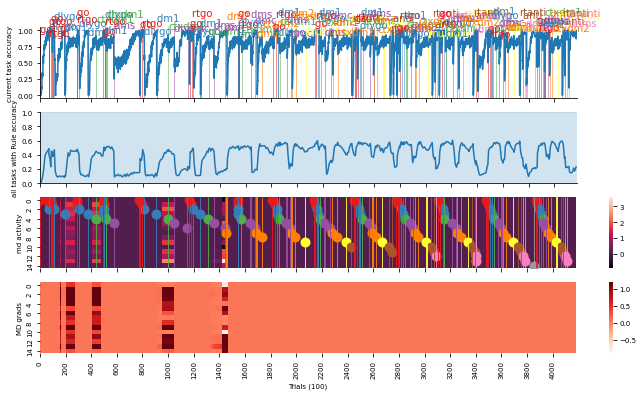

In [26]:
def plot_credit_assignment_inference( config, training_log, testing_log):
    if len(training_log.bu_context_ids) > 0: context_ids =  training_log.bu_context_ids
    elif len(training_log.td_context_ids) > 0: context_ids =  training_log.td_context_ids
    else: 
        # len(training_log.md_context_ids) > 0: 
        policy_context_id = np.ones([1,config.md_size])/config.md_size
        context_ids = [policy_context_id.repeat(config.batch_size, 0)] * training_log.stamps[-1]

    
    mg = np.stack(np.stack([bci.mean(0) for bci in context_ids]))
    # mg = mg.mean(1) #(7957, 15) # average across batch

    x0, x1 = 0, training_log.stamps[-1]
    no_of_values = len(config.tasks)
    norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
    cmap_obj = mpl.cm.get_cmap('Set1') # tab20b tab20
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

    switches=  training_log.switch_trialxxbatch[:] 
    # switches=  training_log.switch_trialxxbatch[1:] # earlier on I must have added zero as a switch trial 

    fig, axes = plt.subplots(4,1, figsize=[12,6], sharex = True)

    ax = axes[0]
    print(ax.get_position())
    ax.set_position(matplotlib.transforms.Bbox([[0.125, 0.715], [.747, 0.880]]))

    ax.plot(np.array(training_log.stamps)[x0:x1], np.array(training_log.accuracies)[x0:x1])
    for ri in range(len(switches)-1):
        ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri]+1, color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.5)
        id = training_log.switch_task_id[ri]
        task_name = config.human_task_names[id]
        ax.text(training_log.switch_trialxxbatch[ri], 1.0 + np.random.uniform(-0.1, 0.25), task_name, color= cmap.to_rgba(id) , fontsize=10)
    ax.set_ylabel('current task accuracy')
    ax.set_xticks(list(range(0, x1, 200)))
    ax.set_xticklabels([str(i) for i in list(range(0, x1, 200))])
    # ax.set_xlim([x0, x1])
    # for ri in range(len(training_log.switch_trialxxbatch)-1):
    #     ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri+1], color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.2)
    ax = axes[1]
    t = 0
    d = training_log.stamps[-1]
    average_acc =[]
    taa = []
    for logi in range(config.num_of_tasks):
        taa.append([test_acc[logi] for test_acc in testing_log.accuracies])
    average_acc.append(np.stack(taa))

    testing_t = convert_train_to_test_idx(training_log, testing_log, t)
    testing_e =convert_train_to_test_idx(training_log, testing_log, t+d)
    ax.plot(testing_log.stamps[testing_t:testing_e], average_acc[0].mean(0)[testing_t:testing_e])
    ax.axvspan(0, d, color='tab:blue', alpha=0.2)
    ax.set_ylim([0,1])
    ax.set_ylabel('all tasks with Rule accuracy')
    # ax.set_title('With task rule input provided')
    # print(ax.get_position())
    ax.set_position(matplotlib.transforms.Bbox([[0.125, 0.519], [.747, 0.683]]))    

    ax = axes[2]
    mtd = mg.squeeze()# np.stack(context_ids)
    # mtd = tdci.mean(1) # (7729, 15)
    im = sns.heatmap(mtd.T, ax = ax)
    ax.set_xlim([x0, x1])
    ax.set_ylabel('md activity')
    # ax.colorbar()
    # plt.colorbar(im) #, ax=ax.ravel().tolist())


    ax.set_xlim([x0, x1])

    # ax.set_ylim([0,1])
    for ri in range(len(switches)-1):
        # print(ri)
        ax.scatter(switches[ri], (training_log.switch_task_id[ri]+0.5), color =cmap.to_rgba(training_log.switch_task_id[ri]) ,  linewidth=4, )#alpha=0.2)
        ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri]+1, color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.9)

    ax = axes[3]
    ax = sns.heatmap(mg.T, cmap='Reds', ax = ax, vmax=mg.max()/3)
    ax.set_xticks(list(range(0, x1, 200)))
    ax.set_xticklabels([str(i) for i in list(range(0, x1, 200))])
    ax.set_xlim([x0, x1])
    ax.set_ylabel('MD grads')
    ax.set_xlabel('Trials (100)')
    # plt.colorbar(ax)

    # sample_rate = 1
    # hm = sns.heatmap(mg.T, cmap='Reds', ax = ax)
    # # ax.set_yticklabels([str(i) for i in labels])
    # ax.set_ylabel('MD neuron idx', fontsize=8)
    # ax.set_xticks(list(range(0, x1, 200)))
    # ax.set_xticklabels([str(i) for i in list(range(0, x1, 200))])
    # # _=ax.set_xlabel('Trial (1000)', fontsize=8)
    # ax.set_title('MD grads')

    try:
        plt.savefig('./files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_bottom_up_optimizing.jpg', dpi=200)
    except:
        # plt.savefig('./../files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_bottom_up_optimizing.jpg', dpi=200)
        plt.savefig('./../files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_bu_optimizing_many_batches.jpg', dpi=300)
        # plt.savefig('./../files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_policy_optimizing.jpg', dpi=200)
plot_credit_assignment_inference(config, training_log, testing_log)